In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn  as sns
import joblib

In [2]:
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,recall_score,RocCurveDisplay,confusion_matrix,roc_auc_score
from lightgbm import LGBMClassifier,LGBMRegressor

In [3]:
HepatitisC_all = pd.read_excel(f"C:\\Users\\김현종\\Desktop\\HCC Project\\DATA\\CHC_kks_0313.xlsx")
HepatitisC_all.fillna(-1, inplace=True)
HepatitisC_all.head()

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,Albumin48,LSM_FU48,APRI48,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time
0,2435.0,5,950313630,김기현,48.0,0,0.0,0.0,2.0,28.4,...,4.0,-1.0,1.666667,9.849371,59.531350,12.0,1,366.0,0,743.0
1,-1.0,10,1263102,오종섭,79.0,1,0.0,0.0,1.0,-1.0,...,4.0,-1.0,0.778146,5.242479,70.746189,14.0,1,370.0,0,1943.0
2,2173.0,5,140236064,박영미,75.0,1,0.0,0.0,1.0,-1.0,...,4.6,-1.0,0.440252,3.154556,54.780730,14.0,1,371.0,0,1953.0
3,-1.0,10,1671998,서숙경,82.0,1,0.0,0.0,1.0,-1.0,...,3.1,-1.0,1.772152,13.700567,77.444515,18.0,1,373.0,0,422.0
4,2102.0,5,50649314,이영임,80.0,1,1.0,0.0,1.0,-1.0,...,3.5,-1.0,0.228758,1.852941,59.618170,15.0,1,376.0,0,532.0


In [4]:
# RANDOM SEED 설정
seed = 28
np.random.seed(seed)

In [5]:
attr_all = HepatitisC_all.columns
print(attr_all)
HepatitisC_all = HepatitisC_all.iloc[np.random.permutation(len(HepatitisC_all))]

Index(['no', 'Site', 'ID', 'name', 'Age0', 'Gender', 'DM', 'Fatty_liver',
       'cirrhosis', 'LSM_ini', 'Platelet0', 'AST0', 'ALT0', 'Bilirubin0',
       'Albumin0', 'APRI0', 'FIB40', 'AMAP0', 'MPAGEB0', 'Age48', 'Platelet48',
       'AST48', 'ALT48', 'Bilirubin48', 'Albumin48', 'LSM_FU48', 'APRI48',
       'FIB448', 'AMAP48', 'MPAGEB48', 'HCC', 'HCC_time', 'Death', 'FU_time'],
      dtype='object')


In [6]:
# attr_pool = ['HCC', 'Age0', 'Platelet0', 'AST0', 'ALT0', 'Bilirubin0', 'Albumin0', 'APRI0', 'FIB40', 'AMAP0', 'MPAGEB0']  # Baseline ONLY
# attr_pool = ['HCC', 'Age48', 'Platelet48', 'AST48', 'ALT48', 'Bilirubin48', 'Albumin48', 'APRI48', 'FIB448', 'AMAP48', 'MPAGEB48']  # 1yr ONLY
attr_pool = ['HCC', 'Age0', 'Age48', 'Platelet0', 'Platelet48', 'AST0', 'AST48', 'ALT0', 'ALT48', 'Bilirubin0', 'Bilirubin48', 'Albumin0', 'Albumin48', 'APRI0', 'APRI48', 'FIB40', 'FIB448', 'AMAP0', 'AMAP48', 'MPAGEB0', 'MPAGEB48']  # Baseline + 1yr

# attr_pool = ['HCC', 'Platelet0', 'APRI0', 'FIB40', 'AMAP0']  # KKS (Baseline ONLY)
# attr_pool = ['HCC', 'Platelet48', 'APRI48', 'FIB448', 'AMAP48']  # KKS (1yr ONLY)
# attr_pool = ['HCC', 'Platelet0', 'Platelet48', 'APRI0', 'APRI48', 'FIB40', 'FIB448', 'AMAP0', 'AMAP48']  # KKS (Baseline + 1yr)

attr = attr_pool

label = 'HCC'

HepatitisC = HepatitisC_all
for at in attr_all:
    
    if not at in attr_pool:
        HepatitisC = HepatitisC.drop(at,axis=1)           

In [7]:
HepatitisC = HepatitisC.astype(float)
print(HepatitisC)

      Age0  Platelet0  AST0   ALT0  Bilirubin0  Albumin0     APRI0     FIB40  \
1669  70.0      217.0  66.0   63.0         0.5      4.60  0.760369  2.682329   
2709  68.0      111.0  82.0   69.0         1.6      4.09  1.846847  6.047491   
768   58.0      234.0  16.0   19.0         2.0      4.30  0.170940  0.909820   
380   62.0       -1.0  60.0  123.0         0.5      3.90 -1.000000 -1.000000   
1920  21.0      325.0  33.0   41.0         1.4      4.20  0.253846  0.333011   
...    ...        ...   ...    ...         ...       ...       ...       ...   
87    76.0      187.0  15.0   16.0         0.4      4.60  0.200535  1.524064   
2036  52.0      142.0  25.0   28.0         0.7      4.40  0.440141  1.730119   
1302  61.0      162.0  59.0   86.0         0.5      4.10  0.910494  2.395618   
1541  52.0       78.0  62.0   22.0         0.5      4.00  1.987179  8.812296   
1281  40.0      209.0  22.0   19.0         1.1      4.00  0.263158  0.965961   

         AMAP0  MPAGEB0  ...  Platelet4

In [8]:
columns = HepatitisC.columns
del_rows = []
for irow in range(len(HepatitisC)):
    
    missing_counts = 0
    for col in columns:
        if HepatitisC[col][irow] <0:
            missing_counts += 1
        
    if missing_counts>0:
        del_rows.append(irow)
        
del_rows = np.array(del_rows)        

HepatitisC = HepatitisC.drop(del_rows, axis = 0)

In [9]:
for at in attr_pool:
    
    if not at in attr:
        HepatitisC = HepatitisC.drop(at,axis=1)

In [10]:
HepatitisC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1984 entries, 1669 to 1281
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age0         1984 non-null   float64
 1   Platelet0    1984 non-null   float64
 2   AST0         1984 non-null   float64
 3   ALT0         1984 non-null   float64
 4   Bilirubin0   1984 non-null   float64
 5   Albumin0     1984 non-null   float64
 6   APRI0        1984 non-null   float64
 7   FIB40        1984 non-null   float64
 8   AMAP0        1984 non-null   float64
 9   MPAGEB0      1984 non-null   float64
 10  Age48        1984 non-null   float64
 11  Platelet48   1984 non-null   float64
 12  AST48        1984 non-null   float64
 13  ALT48        1984 non-null   float64
 14  Bilirubin48  1984 non-null   float64
 15  Albumin48    1984 non-null   float64
 16  APRI48       1984 non-null   float64
 17  FIB448       1984 non-null   float64
 18  AMAP48       1984 non-null   float64
 19  MPAGEB48

In [11]:
HepatitisC.HCC.value_counts()

HCC
0.0    1854
1.0     130
Name: count, dtype: int64

In [12]:
HepatitisC

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,...,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48,HCC
1669,70.0,217.0,66.0,63.0,0.5,4.60,0.760369,2.682329,47.77080,13.0,...,200.0,25.0,14.0,0.4,4.60,0.312500,2.371944,49.12015,13.0,0.0
2709,68.0,111.0,82.0,69.0,1.6,4.09,1.846847,6.047491,56.63066,13.0,...,117.0,45.0,33.0,1.1,3.93,0.961538,4.619753,56.72465,14.0,0.0
768,58.0,234.0,16.0,19.0,2.0,4.30,0.170940,0.909820,49.89281,11.0,...,335.0,19.0,23.0,3.0,4.00,0.141791,0.697745,44.66921,9.0,0.0
1920,21.0,325.0,33.0,41.0,1.4,4.20,0.253846,0.333011,22.62010,0.0,...,348.0,16.0,12.0,0.8,4.30,0.114943,0.291993,20.67096,0.0,0.0
1613,65.0,108.0,30.0,23.0,1.2,3.90,0.694444,3.764844,55.87319,14.0,...,145.0,24.0,16.0,0.9,3.80,0.413793,2.731034,53.78325,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,76.0,187.0,15.0,16.0,0.4,4.60,0.200535,1.524064,58.05719,16.0,...,204.0,12.0,4.0,0.4,5.00,0.147059,2.264706,56.20489,15.0,1.0
2036,52.0,142.0,25.0,28.0,0.7,4.40,0.440141,1.730119,52.42945,13.0,...,145.0,21.0,24.0,0.4,4.50,0.362069,1.566829,51.83441,13.0,0.0
1302,61.0,162.0,59.0,86.0,0.5,4.10,0.910494,2.395618,49.22293,12.0,...,178.0,33.0,25.0,0.7,4.20,0.463483,2.298876,48.58241,12.0,0.0
1541,52.0,78.0,62.0,22.0,0.5,4.00,1.987179,8.812296,51.53096,12.0,...,81.0,35.0,23.0,0.7,4.70,1.080247,4.775238,50.10929,12.0,0.0


## Data split

In [13]:
X = HepatitisC.drop('HCC',axis=1)
y = HepatitisC['HCC']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=seed)

In [14]:
y_train.value_counts()

HCC
0.0    1301
1.0      87
Name: count, dtype: int64

In [15]:
y_test.value_counts()

HCC
0.0    553
1.0     43
Name: count, dtype: int64

In [16]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=seed)
# X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# print('SMOTE 적용 후: ', y_train_over.value_counts())

In [17]:
X_train

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48
946,53.0,399.0,38.0,53.0,0.5,4.60,0.238095,0.693344,34.56836,9.0,54.0,376.0,26.0,14.0,0.3,4.70,0.172872,0.997965,35.77908,9.0
738,67.0,227.0,61.0,11.0,0.5,4.50,0.671806,5.428532,52.17768,13.0,68.0,218.0,25.0,8.0,0.8,5.00,0.286697,2.757068,52.24664,13.0
1268,70.0,117.0,102.0,97.0,1.1,3.30,2.179487,6.196215,58.87526,17.0,71.0,163.0,27.0,15.0,0.8,4.10,0.414110,3.036609,53.65533,14.0
434,76.0,187.0,64.0,35.0,0.4,4.76,0.855615,4.396610,51.58844,14.0,77.0,170.0,33.0,29.0,0.4,4.46,0.485294,2.775599,53.97631,14.0
924,48.0,143.0,22.0,18.0,0.7,4.50,0.384615,1.740571,44.43422,9.0,49.0,139.0,12.0,4.0,0.6,4.28,0.215827,2.115108,45.57684,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,61.0,189.0,17.0,19.0,0.3,4.40,0.224868,1.258752,52.11413,14.0,62.0,246.0,17.0,18.0,0.3,3.80,0.172764,1.009879,50.32250,14.0
465,74.0,172.0,63.0,14.0,0.5,4.01,0.915698,7.244023,60.10178,16.0,75.0,194.0,27.0,21.0,0.5,4.34,0.347938,2.277790,58.10479,16.0
2337,49.0,135.0,55.0,88.0,0.5,4.00,1.018519,2.128059,52.47883,11.0,50.0,185.0,33.0,44.0,0.8,4.40,0.445946,1.344578,48.83009,12.0
1101,61.0,212.0,24.0,17.0,0.5,4.80,0.283019,1.674869,43.89949,11.0,62.0,223.0,18.0,13.0,0.5,4.70,0.201794,1.387994,43.83786,11.0


In [18]:
# X_train_over

# # Import External Validation Dataset

In [19]:
ext_val_all = pd.read_excel(f"C:\\Users\\김현종\\Desktop\\HCC Project\\DATA\\External_Validation_0318.xlsx")
ext_val_all.fillna(-1, inplace=True)
ext_val_all.head()

,no,Site,ID,name,Age0,Gender,DM,Fatty_liver,cirrhosis,LSM_ini,...,Albumin48,LSM_FU48,APRI48,FIB448,AMAP48,MPAGEB48,HCC,HCC_time,Death,FU_time
0,1,1,8095788,-1.0,48.9,1,1,-1.0,0.0,8.2,...,2.1,,0.792254,3.381609,65.082410,14.0,0,2237,0,2237
1,2,1,603254,-1.0,79.6,0,1,-1.0,0.0,-1.0,...,2.4,,1.160000,7.243432,73.385288,18.0,0,1149,0,1149
2,3,1,7784929,-1.0,93.0,0,1,-1.0,0.0,21.6,...,2.4,27.4,0.267094,2.341913,72.025574,16.0,0,932,0,932
3,4,1,8376770,-1.0,76.3,0,0,-1.0,0.0,16.6,...,2.6,,0.824742,6.499159,74.530896,19.0,0,1827,0,1827
4,6,1,7525004,-1.0,68.4,1,0,-1.0,0.0,-1.0,...,3.1,,1.136364,8.623067,79.592614,18.0,0,1488,0,1488


In [20]:
Ext_val = ext_val_all

for at in attr_all:
    if at not in attr_pool:
        Ext_val = Ext_val.drop(at, axis=1)

In [21]:
ext_columns = Ext_val.columns
del_rows = []
for irow in range(len(Ext_val)):
    
    missing_counts = 0
    for col in ext_columns:
        if Ext_val[col][irow] <0:
            missing_counts += 1
        
    if missing_counts>0:
        del_rows.append(irow)
        
del_rows = np.array(del_rows)        

Ext_val = Ext_val.drop(del_rows, axis = 0)

In [22]:
ext_X = Ext_val.drop('HCC', axis=1)
ext_y = Ext_val['HCC']

In [23]:
ext_y

0       0
1       0
2       0
3       0
4       0
       ..
6352    0
6353    1
6354    0
6356    0
6357    0
Name: HCC, Length: 5309, dtype: int64

### Save test sets and results to CSV

In [24]:
### Due to random samples, indices are shuffled-> reorganize sample orders and run the prediction -> save to csv
attr_x = X_test.columns
row_num = y_test.index  # 환자 번호 (CSV 파일에서 no.)
Xt = np.moveaxis(np.array(X_test.values.tolist()),0,-1)  # X_test.values.tolist() --> 645명의 환자에 대한 8 attributes에 따른 data를 list로 저장
# Xt.shape: (8, 645)
for ii in range(Xt.shape[0]):
    if ii == 0:
        x_test_re = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
    else:
        tmp = pd.DataFrame({str(attr_x[ii]):Xt[ii]})
        x_test_re = x_test_re.join(tmp)
# x_test_re: 재배열된 X_test

# [HCC, name, ID] DataFrame을 생성한다
gt =  pd.DataFrame({'HCC':np.array(y_test.values.tolist())})
name = pd.DataFrame({'Name':np.array(HepatitisC_all['name'][row_num].values.tolist())})
ID = pd.DataFrame({'ID':np.array(HepatitisC_all['ID'][row_num].values.tolist())})

In [25]:
x_test_re

,Age0,Platelet0,AST0,ALT0,Bilirubin0,Albumin0,APRI0,FIB40,AMAP0,MPAGEB0,Age48,Platelet48,AST48,ALT48,Bilirubin48,Albumin48,APRI48,FIB448,AMAP48,MPAGEB48
0,66.0,208.0,29.0,25.0,0.7,4.3,0.348558,1.840385,53.92503,13.0,67.0,205.0,18.0,20.0,0.7,4.2,0.219512,1.315462,54.81126,13.0
1,78.0,110.0,290.0,99.0,0.7,4.0,6.590909,20.667232,66.26550,17.0,79.0,144.0,34.0,25.0,0.9,4.7,0.590278,3.730556,62.66568,17.0
2,72.0,185.0,21.0,11.0,0.5,4.3,0.283784,2.464244,51.58047,14.0,73.0,159.0,37.0,26.0,0.6,4.3,0.581761,3.331507,53.91686,14.0
3,61.0,137.0,39.0,85.0,1.9,3.6,0.711679,1.883495,59.56929,16.0,62.0,122.0,21.0,13.0,2.1,4.4,0.430328,2.959917,58.86921,15.0
4,69.0,216.0,51.0,94.0,0.5,4.3,0.590278,1.680357,54.28866,13.0,70.0,219.0,16.0,13.0,0.5,5.0,0.182648,1.418411,52.55358,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,78.0,92.0,75.0,173.0,1.0,3.7,2.038043,4.834427,68.64711,19.0,79.0,102.0,17.0,14.0,0.9,4.0,0.416667,3.518940,67.44749,17.0
592,61.0,292.0,81.0,36.0,0.9,4.1,0.693493,2.820205,46.99457,11.0,62.0,311.0,31.0,17.0,0.5,4.6,0.249196,1.498886,44.18245,11.0
593,57.0,111.0,24.0,31.0,0.6,4.0,0.540541,2.213514,57.52341,13.0,58.0,169.0,14.0,14.0,0.5,4.7,0.207101,1.284119,51.89473,12.0
594,74.0,168.0,49.0,19.0,1.5,3.3,0.729167,4.951556,57.33614,16.0,75.0,194.0,28.0,17.0,0.9,4.0,0.360825,2.625386,53.56800,14.0


## 3. Random Forest

In [26]:
forest_clf = RandomForestClassifier()
parameters = {'max_depth':[3,5,7,9], 'min_samples_leaf':[5,10,15,20]}

f_clf_GS = GridSearchCV(forest_clf, parameters, cv=3)
f_clf_GS.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [5, 10, 15, 20]})

In [27]:
f_clf_GS.best_estimator_

RandomForestClassifier(max_depth=3, min_samples_leaf=5)

In [28]:
forest_clf = RandomForestClassifier(max_depth=3, min_samples_leaf=10)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=10)

In [29]:
print('Train AUC-ROC score is', roc_auc_score(y_train, f_clf_GS.predict_proba(X_train)[:, 1]))
print('Test AUC-ROC score is', roc_auc_score(y_test, f_clf_GS.predict_proba(X_test)[:, 1]))

Train AUC-ROC score is 0.9016671525881949
Test AUC-ROC score is 0.8516758484376971


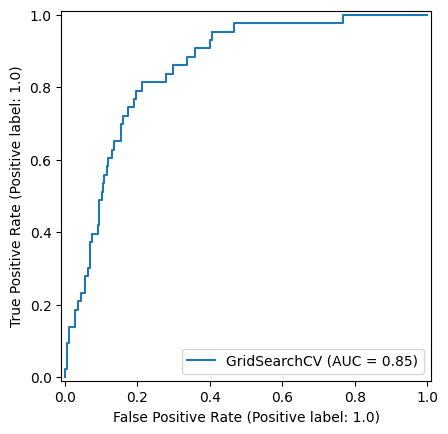

In [30]:
RocCurveDisplay.from_estimator(f_clf_GS,X_test,y_test)
y_test_pred_RF = f_clf_GS.predict_proba(x_test_re)[:, 1]

pred = pd.DataFrame({'Predition':np.array(y_test_pred_RF)})
# results = ID.join(name)
# results = results.join(x_test_re)
# results = results.join(gt)
# results = results.join(pred)

# 결과를 CSV/EXCEL 파일로 저장
# results.to_csv('Results_Random_Forest.csv', index=False)
# results.to_excel('Results_Random_Forest.xlsx', index=False)

In [31]:
thresholds = np.linspace(0.06,0.09,10)
print(thresholds)
for th in thresholds:
    y_pred = np.zeros((y_test_pred_RF.shape),dtype = float)
    y_pred[y_test_pred_RF>th] = 1
    TP = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==1)]
    FP = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==1)]
    TN = [k for k in range(len(gt.values)) if (gt.values[k] == 0 and y_pred[k] ==0)]
    FN = [k for k in range(len(gt.values)) if (gt.values[k] == 1 and y_pred[k] ==0)]
    print("Confusion matrix: threshold - %.3f"%th)
    print("T    |      Prediction      | ")
    print("R    |     N     |    P     | ")
    print("U  0 |    %.3f   |   %.3f   | "%(float(len(TN))/float(len(FP)+len(TN)),float(len(FP))/float(len(FP)+len(TN))))
    print("E  1 |    %.3f   |   %.3f   | "%(float(len(FN))/float(len(TP)+len(FN)),float(len(TP))/float(len(TP)+len(FN))))
    
    # print(confusion_matrix(y_test,y_pred,normalize='true'))

[0.06       0.06333333 0.06666667 0.07       0.07333333 0.07666667
 0.08       0.08333333 0.08666667 0.09      ]
Confusion matrix: threshold - 0.060
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.759   |   0.241   | 
E  1 |    0.186   |   0.814   | 
Confusion matrix: threshold - 0.063
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.779   |   0.221   | 
E  1 |    0.186   |   0.814   | 
Confusion matrix: threshold - 0.067
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.783   |   0.217   | 
E  1 |    0.186   |   0.814   | 
Confusion matrix: threshold - 0.070
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.794   |   0.206   | 
E  1 |    0.209   |   0.791   | 
Confusion matrix: threshold - 0.073
T    |      Prediction      | 
R    |     N     |    P     | 
U  0 |    0.803   |   0.197   | 
E  1 |    0.209   |   0.791   | 
Confusion matrix: threshold - 0.077
T    |      Prediction      | 


In [32]:
# joblib.dump(forest_clf, "C:/Users/김현종/Desktop/HCC Project/Save_Model/RandomForest.joblib")

## AUROC with 95% confidence interval

In [33]:
import sklearn.metrics
import numpy as np
import matplotlib.axes
import matplotlib.figure
import matplotlib.pyplot as plt
import pandas as pd

import calc_froc

In [34]:
from calc_froc import plot_roc_with_ci,plot_roc_with_ci

In [35]:
from typing import List, Tuple, Union, Any

In [36]:
def roc_with_ci(
    preds: np.array,
    labels: np.array,
    ci: float = 95,
    nbst: int = 1000,
    seed: Union[int, np.random.Generator] = None,
) -> dict:
    fprs, tprs, ths = sklearn.metrics.roc_curve(labels, preds)
    auc = sklearn.metrics.auc(fprs, tprs)

    # bootstrap to get confidence interval
    tpr_bst_list = []
    auc_bst_list = []
    rng = np.random.default_rng(seed)
    for i in range(nbst):
        # sampling with replacement
        ind = rng.integers(0, len(labels), len(labels))
        label_bst = labels[ind]
        pred_bst = preds[ind]

        # calculate ROC for each bootstrap
        fpr_bst, tpr_bst, _ = sklearn.metrics.roc_curve(label_bst, pred_bst)

        # resample the roc for each fprs
        tpr_sample = np.interp(fprs, fpr_bst, tpr_bst)
        tpr_bst_list.append(tpr_sample)
        auc_bst_list.append(sklearn.metrics.auc(fpr_bst, tpr_bst))

    tpr_bst_list = np.array(tpr_bst_list)
    tprs_ci = np.percentile(tpr_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2], axis=0)
    auc_ci = np.percentile(auc_bst_list, [(100 - ci) / 2, 100 - (100 - ci) / 2])

    return {
        'fprs': fprs,
        'tprs': tprs,
        'ths': ths,
        'tprs_ci': tprs_ci,
        'auc': auc,
        'auc_ci': auc_ci
    }

def roc_with_ci_draw(pred,gt,save_fig_name):
    results = roc_with_ci(np.array(pred),np.array(gt))

    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    linestyle_cycle = ['-', '--']
    fig, ax = plt.subplots(figsize=[6, 4], dpi=300)
    
    color = colors[0]
    linestyle = linestyle_cycle[0]
    
    ax = plot_roc_with_ci(
        ax, results['fprs'], results['tprs'], results['tprs_ci'], color=color, linestyle=linestyle
    )
    
    ax.set_xlabel('False positive')
    ax.set_ylabel('True positive')
    ax.grid(True)
    ax.set_xlim([-0.03, 1])
    ax.set_ylim([-0.03, 1.03])
    ax.legend(['AUC = %.2f $\pm$ 95 %% confidence'%results['auc']],loc=4)
    # plt.savefig(save_fig_name)  # FROC plot 저장
    plt.show()

<>:61: SyntaxWarning: invalid escape sequence '\p'
<>:61: SyntaxWarning: invalid escape sequence '\p'
C:\Users\김현종\AppData\Local\Temp\ipykernel_3032\1492191649.py:61: SyntaxWarning: invalid escape sequence '\p'
  ax.legend(['AUC = %.2f $\pm$ 95 %% confidence'%results['auc']],loc=4)


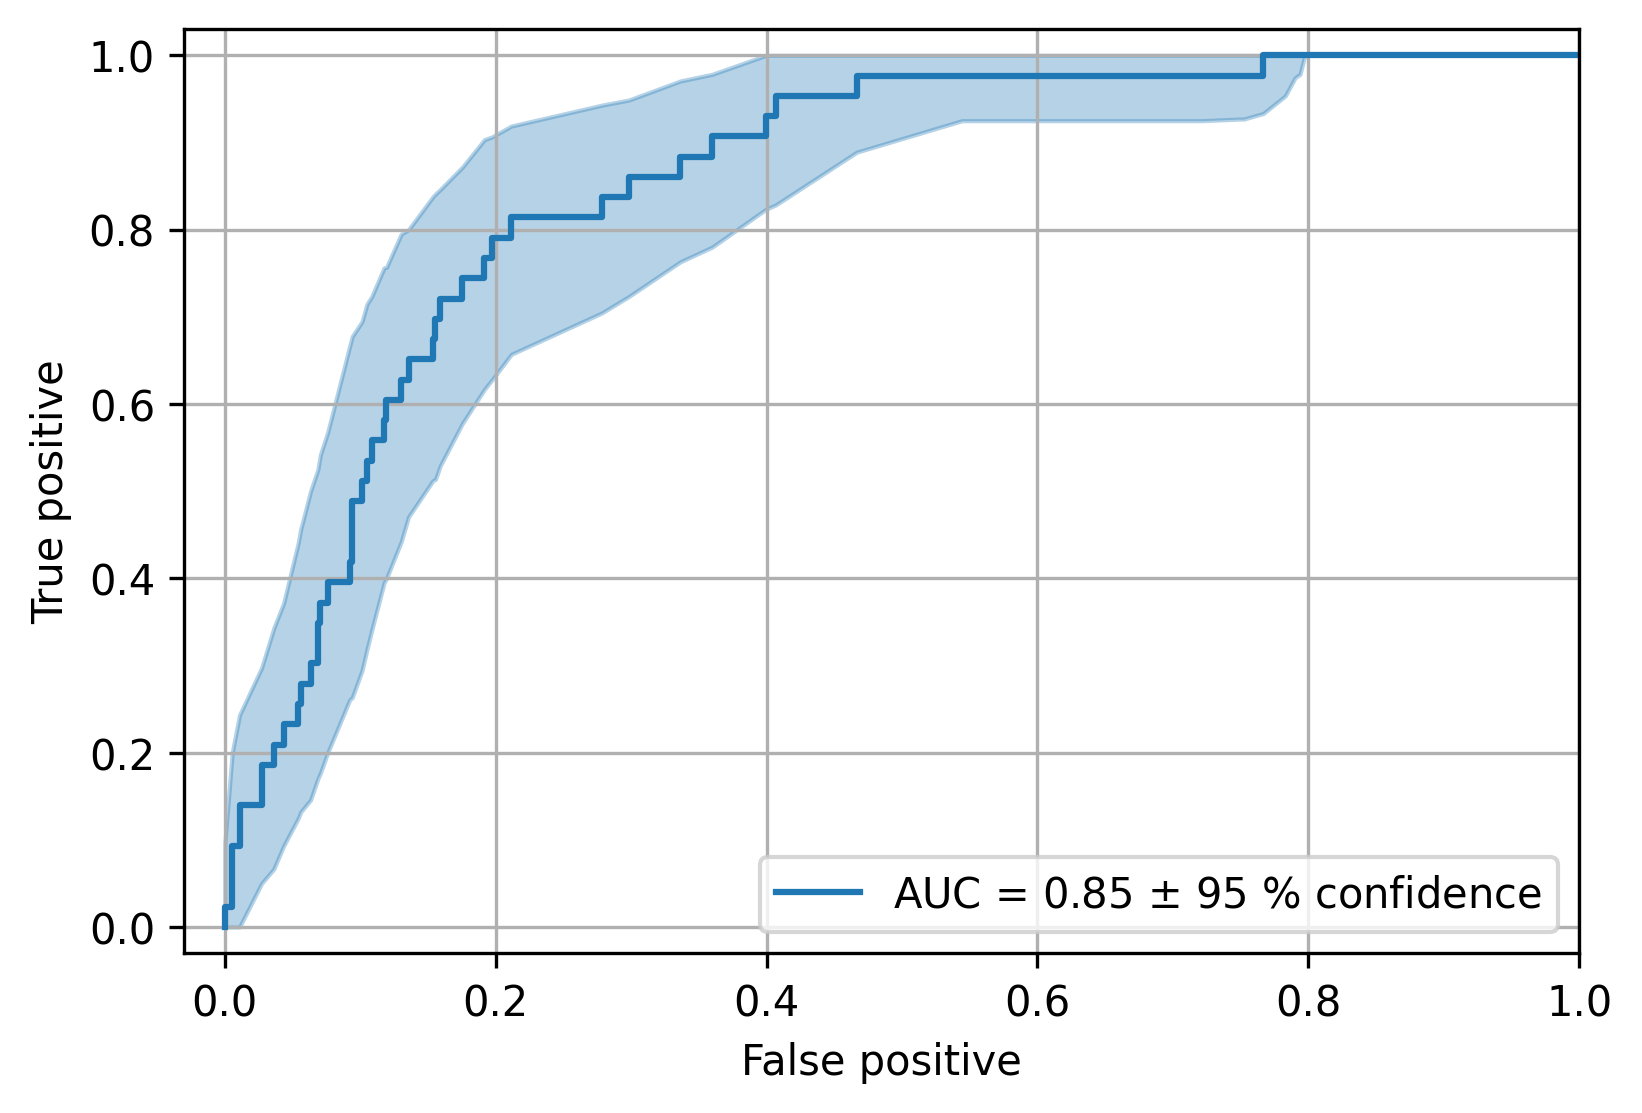

In [37]:
roc_with_ci_draw(y_test_pred_RF,gt,'RandomForest')